In [14]:
# Hydrogen System Prototype - Notebook 

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output, display
import warnings
warnings.filterwarnings('ignore')

# For visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [16]:
# General system configuration
config = {
    'total_capacity_kw': 500,
    'num_electrolyzers': 3,
    'tank_capacity_kg': 1000,
    'target_output_kg_hr': 20,
    'efficiency_baseline': 0.60,  # 60 baseline efficiency
    'operating_hours_per_day': 20
}

# Location-specific parameters (optional - can be customized)
location_params = {
    'location': 'Berlin',
    'avg_temperature': 15,  # °C
    'solar_capacity_kw': 300,
    'wind_capacity_kw': 150,
    'grid_capacity_kw': 50
}

In [17]:
# Generating Historical Training Data 

# Createing 30 days of historical data for training prediction models
np.random.seed(42)
days = 30
hours_per_day = 24

# Generate timestamps
timestamps = pd.date_range(start='2025-01-01', periods=days*hours_per_day, freq='H')

# Generate realistic operational data
historical_data = pd.DataFrame({
    'timestamp': timestamps,
    'energy_input_kw': np.random.normal(450, 50, len(timestamps)).clip(300, 600),
    'temperature_c': np.random.normal(15, 5, len(timestamps)).clip(5, 35),
    'solar_generation_kw': np.random.gamma(2, 50, len(timestamps)).clip(0, 300),
    'wind_generation_kw': np.random.gamma(2, 30, len(timestamps)).clip(0, 150),
    'tank_level_pct': np.random.uniform(40, 90, len(timestamps))
})

# Calculate hydrogen output based on energy input and conditions
historical_data['hydrogen_output_kg_hr'] = (
    historical_data['energy_input_kw'] * 0.04 * 
    (1 + (25 - historical_data['temperature_c']) * 0.005) *
    np.random.uniform(0.95, 1.05, len(timestamps))
).round(2)

# Calculate efficiency

historical_data['efficiency_pct'] = (
    55  # higher base
    + 0.06 * (historical_data['energy_input_kw'] - 400)   # stronger impact of power input
    - 0.25 * abs(historical_data['temperature_c'] - 25)   # moderate temp penalty
    + np.random.normal(0, 2, len(timestamps))             # small noise
).clip(45, 85).round(2)

print(f" Generated {len(historical_data)} hours of historical data")
print("\nFirst 5 rows:")
display(historical_data.head())
print("\nData Statistics:")
display(historical_data.describe())



 Generated 720 hours of historical data

First 5 rows:


,timestamp,energy_input_kw,temperature_c,solar_generation_kw,wind_generation_kw,tank_level_pct,hydrogen_output_kg_hr,efficiency_pct
0,2025-01-01 00:00:00,474.835708,16.539009,133.863481,78.559375,41.721565,19.19,53.55
1,2025-01-01 01:00:00,443.086785,6.449158,184.349366,24.870393,62.291277,19.30,51.26
2,2025-01-01 02:00:00,482.384427,8.259073,111.887177,60.459939,80.832762,20.38,57.04
3,2025-01-01 03:00:00,526.151493,18.716320,47.963119,88.976569,84.261944,22.61,61.06
4,2025-01-01 04:00:00,438.292331,15.854327,191.543501,32.547221,44.335328,18.03,50.35



Data Statistics:


,timestamp,energy_input_kw,temperature_c,solar_generation_kw,wind_generation_kw,tank_level_pct,hydrogen_output_kg_hr,efficiency_pct
count,720,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,2025-01-15 23:30:00,449.447041,15.479221,102.463896,59.821328,65.147057,18.825667,55.390056
min,2025-01-01 00:00:00,300.000000,5.000000,2.295949,0.775815,40.309191,12.290000,45.000000
25%,2025-01-08 11:45:00,415.269321,11.987852,50.140172,29.956479,52.912612,17.250000,52.925000
50%,2025-01-15 23:30:00,449.494515,15.500805,88.345598,51.250822,64.575537,18.835000,55.255000
75%,2025-01-23 11:15:00,481.520855,18.542591,135.484027,80.877489,77.424815,20.195000,57.935000
max,2025-01-30 23:00:00,600.000000,28.161910,300.000000,150.000000,89.967515,24.950000,68.590000
std,NaN,49.039170,4.858075,66.900510,39.197575,14.492970,2.187607,3.775062


In [18]:
# XGBoost ML Models for Predictions

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Feature columns for predictions
feature_cols = ['energy_input_kw', 'temperature_c', 'solar_generation_kw', 
                'wind_generation_kw', 'tank_level_pct']

# Prepare features and targets
X = historical_data[feature_cols].copy()
y_hydrogen = historical_data['hydrogen_output_kg_hr'].copy()
y_efficiency = historical_data['efficiency_pct'].copy()

# Split data into train and test sets
X_train, X_test, y_h2_train, y_h2_test = train_test_split(
    X, y_hydrogen, test_size=0.2, random_state=42
)
_, _, y_eff_train, y_eff_test = train_test_split(
    X, y_efficiency, test_size=0.2, random_state=42
)


In [19]:
model_hydrogen = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    objective='reg:squarederror'
)

model_hydrogen.fit(X_train, y_h2_train, verbose=False)

y_h2_pred = model_hydrogen.predict(X_test)
h2_mae = mean_absolute_error(y_h2_test, y_h2_pred)
h2_r2 = r2_score(y_h2_test, y_h2_pred)
print(f"  Model trained successfully!")
print(f"  Test MAE: {h2_mae:.3f} kg/hr")
print(f"  Test R² Score: {h2_r2:.3f}\n")

  Model trained successfully!
  Test MAE: 0.541 kg/hr
  Test R² Score: 0.926



In [20]:
model_efficiency = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    objective='reg:squarederror'
)

model_efficiency.fit(X_train, y_eff_train, verbose=False)

# Evaluate on test set
y_eff_pred = model_efficiency.predict(X_test)
eff_mae = mean_absolute_error(y_eff_test, y_eff_pred)
eff_r2 = r2_score(y_eff_test, y_eff_pred)

print(f"  Model trained successfully!")
print(f"  Test MAE: {eff_mae:.3f}%")
print(f"  Test R² Score: {eff_r2:.3f}\n")

  Model trained successfully!
  Test MAE: 1.804%
  Test R² Score: 0.645



In [21]:
# Defining Prediction Functions which uses trained models

def predict_hydrogen_output(energy_kw, temperature_c, solar_kw=0, wind_kw=0, tank_level=70):
    """
    Predict hydrogen output using trained XGBoost model
    """
    input_data = pd.DataFrame({
        'energy_input_kw': [energy_kw],
        'temperature_c': [temperature_c],
        'solar_generation_kw': [solar_kw],
        'wind_generation_kw': [wind_kw],
        'tank_level_pct': [tank_level]
    })
    prediction = model_hydrogen.predict(input_data)[0]
    return round(prediction, 2)

def predict_efficiency(energy_kw, temperature_c, solar_kw=0, wind_kw=0, tank_level=70):
    """
    Predict system efficiency using trained XGBoost model
    """
    input_data = pd.DataFrame({
        'energy_input_kw': [energy_kw],
        'temperature_c': [temperature_c],
        'solar_generation_kw': [solar_kw],
        'wind_generation_kw': [wind_kw],
        'tank_level_pct': [tank_level]
    })
    prediction = model_efficiency.predict(input_data)[0]
    return round(prediction, 2)

In [22]:
# Testing our model on random user data 

test_energy = 480
test_temp = 20
test_solar = 150
test_wind = 80
test_tank = 65

predicted_h2 = predict_hydrogen_output(test_energy, test_temp, test_solar, test_wind, test_tank)
predicted_eff = predict_efficiency(test_energy, test_temp, test_solar, test_wind, test_tank)

print(f"\nInput Parameters:")
print(f"  Energy: {test_energy} kW")
print(f"  Temperature: {test_temp}°C")
print(f"  Solar Generation: {test_solar} kW")
print(f"  Wind Generation: {test_wind} kW")
print(f"  Tank Level: {test_tank}%")
print(f"\nPredictions:")
print(f"  Predicted H₂ Output: {predicted_h2} kg/hr")
print(f"  Predicted Efficiency: {predicted_eff}%")


Input Parameters:
  Energy: 480 kW
  Temperature: 20°C
  Solar Generation: 150 kW
  Wind Generation: 80 kW
  Tank Level: 65%

Predictions:
  Predicted H₂ Output: 19.3700008392334 kg/hr
  Predicted Efficiency: 58.27000045776367%


In [23]:
# Initialize current operating data (simulating real-time system)
current_operating_data = pd.DataFrame({
    'timestamp': pd.date_range(start='2025-10-13 00:00', periods=24, freq='H'),
    'energy_input_kw': np.zeros(24),
    'temperature_c': np.zeros(24),
    'solar_generation_kw': np.zeros(24),
    'wind_generation_kw': np.zeros(24),
    'tank_level_pct': np.zeros(24),
    'hydrogen_output_kg_hr': np.zeros(24),
    'predicted_hydrogen_kg_hr': np.zeros(24),
    'efficiency_pct': np.zeros(24),
    'predicted_efficiency_pct': np.zeros(24)
})

print("📋 Current operating dataframe initialized")
print(f"Shape: {current_operating_data.shape}")
display(current_operating_data.head())

📋 Current operating dataframe initialized
Shape: (24, 10)


,timestamp,energy_input_kw,temperature_c,solar_generation_kw,wind_generation_kw,tank_level_pct,hydrogen_output_kg_hr,predicted_hydrogen_kg_hr,efficiency_pct,predicted_efficiency_pct
0,2025-10-13 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-10-13 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-10-13 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-10-13 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-10-13 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Live Data Simulation Function

# Simulate one live sensor reading from the hydrogen system
# Returns a dictionary with current readings

def simulate_live_reading():
    reading = {
        'energy_input_kw': round(np.random.normal(450, 50), 2),
        'temperature_c': round(np.random.normal(15, 5), 2),
        'solar_generation_kw': max(0, round(np.random.gamma(2, 50), 2)),
        'wind_generation_kw': max(0, round(np.random.gamma(2, 30), 2)),
        'tank_level_pct': round(np.random.uniform(40, 90), 2)
    }
    
    # Calculate actual output with some noise
    reading['hydrogen_output_kg_hr'] = round(
        predict_hydrogen_output(
            reading['energy_input_kw'], 
            reading['temperature_c']
        ) * np.random.uniform(0.97, 1.03),
        2
    )
    
    # Add predictions
    reading['predicted_hydrogen_kg_hr'] = predict_hydrogen_output(
        reading['energy_input_kw'], 
        reading['temperature_c']
    )
    
    reading['efficiency_pct'] = round(
    55 
    + 0.06 * (reading['energy_input_kw'] - 400)
    - 0.25 * abs(reading['temperature_c'] - 25)
    + np.random.normal(0, 2),
    2
    )
    reading['efficiency_pct'] = max(45, min(85, reading['efficiency_pct']))

    reading['predicted_efficiency_pct'] = predict_efficiency(
        reading['energy_input_kw'],
        reading['temperature_c'],
        reading['tank_level_pct']
    )
    
    return reading

# Test the simulator
test_reading = simulate_live_reading()
print(" Live Data Simulator Ready!")
print("\nSample reading:")
for key, value in test_reading.items():
    print(f"  {key}: {value}")


 Live Data Simulator Ready!

Sample reading:
  energy_input_kw: 539.58
  temperature_c: 25.44
  solar_generation_kw: 137.87
  wind_generation_kw: 50.04
  tank_level_pct: 75.06
  hydrogen_output_kg_hr: 20.979999542236328
  predicted_hydrogen_kg_hr: 20.6200008392334
  efficiency_pct: 60.18
  predicted_efficiency_pct: 62.25


In [25]:
# Live Dashboard Charts function 

def create_live_dashboard(df, num_points=10):
    """
    Create interactive dashboard with multiple charts
    Shows last 'num_points' data points
    """
    # Filter to last N points
    df_plot = df.tail(num_points).copy()
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Hydrogen Output (Actual vs Predicted)',
            'System Efficiency',
            'Energy Sources',
            'Tank Level'
        ),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # Chart 1: Hydrogen Output
    fig.add_trace(
        go.Scatter(x=df_plot['timestamp'], y=df_plot['hydrogen_output_kg_hr'],
                   name='Actual Output', line=dict(color='blue', width=3)),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=df_plot['timestamp'], y=df_plot['predicted_hydrogen_kg_hr'],
                   name='Predicted Output', line=dict(color='red', dash='dash')),
        row=1, col=1
    )
    
    # Chart 2: Efficiency
    fig.add_trace(
        go.Scatter(x=df_plot['timestamp'], y=df_plot['efficiency_pct'],
                   name='Actual Efficiency', line=dict(color='green', width=3)),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(x=df_plot['timestamp'], y=df_plot['predicted_efficiency_pct'],
                   name='Predicted Efficiency', line=dict(color='orange', dash='dash')),
        row=1, col=2
    )
    
    # Chart 3: Energy Sources
    fig.add_trace(
        go.Bar(x=df_plot['timestamp'], y=df_plot['solar_generation_kw'],
               name='Solar', marker_color='gold'),
        row=2, col=1
    )
    fig.add_trace(
        go.Bar(x=df_plot['timestamp'], y=df_plot['wind_generation_kw'],
               name='Wind', marker_color='lightblue'),
        row=2, col=1
    )
    
    # Chart 4: Tank Level
    fig.add_trace(
        go.Scatter(x=df_plot['timestamp'], y=df_plot['tank_level_pct'],
                   name='Tank Level', fill='tozeroy',
                   line=dict(color='purple', width=2)),
        row=2, col=2
    )
    
    # Update layout
    fig.update_xaxes(title_text="Time", row=1, col=1)
    fig.update_xaxes(title_text="Time", row=1, col=2)
    fig.update_xaxes(title_text="Time", row=2, col=1)
    fig.update_xaxes(title_text="Time", row=2, col=2)
    
    fig.update_yaxes(title_text="kg/hr", row=1, col=1)
    fig.update_yaxes(title_text="%", row=1, col=2)
    fig.update_yaxes(title_text="kW", row=2, col=1)
    fig.update_yaxes(title_text="%", row=2, col=2)
    
    fig.update_layout(height=700, showlegend=True, title_text="Hydrogen System Live Dashboard")
    
    return fig

⏱️  Iteration 10/10
Current H₂ Output: 17.8799991607666 kg/hr
Predicted H₂ Output: 18.420000076293945 kg/hr
Efficiency: 56.55%



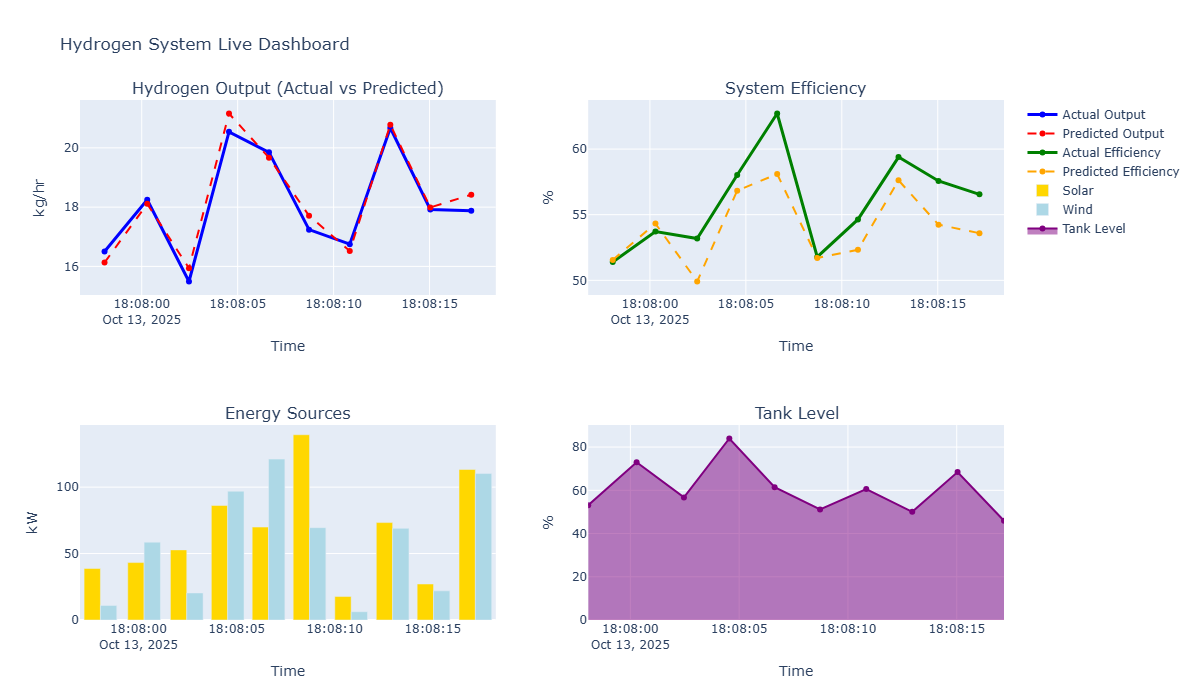

,timestamp,hydrogen_output_kg_hr,predicted_hydrogen_kg_hr,efficiency_pct
0,2025-10-13 18:07:58.062129,16.500000,16.129999,51.40
1,2025-10-13 18:08:00.287477,18.250000,18.110001,53.71
2,2025-10-13 18:08:02.462463,15.490000,15.940000,53.18
3,2025-10-13 18:08:04.548355,20.540001,21.160000,58.02
4,2025-10-13 18:08:06.630931,19.850000,19.670000,62.71
5,2025-10-13 18:08:08.719726,17.240000,17.709999,51.78
6,2025-10-13 18:08:10.841640,16.750000,16.520000,54.64
7,2025-10-13 18:08:12.955774,20.670000,20.780001,59.39
8,2025-10-13 18:08:15.039853,17.920000,17.990000,57.57
9,2025-10-13 18:08:17.173262,17.879999,18.420000,56.55



 Short simulation complete!


In [29]:
# Run Live Simulation (Short Version - 10 iterations)

# Create list to collect all readings
simulation_data = []

for i in range(10):
    # Get new reading
    new_reading = simulate_live_reading()
    new_reading['timestamp'] = pd.Timestamp.now() + pd.Timedelta(seconds=i)
    
    # Append to list
    simulation_data.append(new_reading)
    
    # Create dataframe from collected data
    simulation_df = pd.DataFrame(simulation_data)
    
    # Clear output and show updated dashboard
    clear_output(wait=True)
    
    print(f"⏱️  Iteration {i+1}/10")
    print(f"Current H₂ Output: {new_reading['hydrogen_output_kg_hr']} kg/hr")
    print(f"Predicted H₂ Output: {new_reading['predicted_hydrogen_kg_hr']} kg/hr")
    print(f"Efficiency: {new_reading['efficiency_pct']}%\n")
    
    # Show dashboard every iteration
    fig = create_live_dashboard(simulation_df, num_points=len(simulation_df))
    fig.show()
    
    # Display current data
    display(simulation_df[['timestamp', 'hydrogen_output_kg_hr', 
                           'predicted_hydrogen_kg_hr', 'efficiency_pct']])
    
    time.sleep(1)  # Wait 1 second between updates
print("\n Short simulation complete!")